# Charleston Shipping Lanes Risk Analysis

### Research Question

> Presently, there are no recommended lanes off Charleston. Would recommended lane/s reduce the relative risk of interactions between commercial vessels and right whales? Can it be determined?  If so, what is the expected reduction in risk of interactions and where should the lanes be placed? 

### Modeling Approach

Following Fonnesbeck *et al.* (2008), we will construct a predictive model of right whale encounter that is based on existing aerial survey data and relevant environmental predictors of whale habitat use, such as bathymetry and water temperature. This model will be used as a tool to identify a shipping lane designation that minimizes risk to the migratory northern right whale population.

The metric for risk for a particular lane designation will be the expected encounter rate of whale groups over the total area defined by any candidate lane. To avoid having to account for small-scale factors related to the interaction of whales and ships, risk will be estimated at a relatively coarse scale. Specifically, I will estimate the expected occurrence probability of whale groups over the cells of a 3 x 3 nmi grid in the southern part of the study area, and a 4 x 4 nmi grid in the north.

A key component of the modeling approach is the estimating the rate of encounter with whale groups in each grid cell. These estimates are informed by aerial survey data, which includes both sightings and on-watch effort. The key parameter of interest is the encounter rate, which we will use to model the survey encounters as a Poisson random variable, using the survey effort as an offset.

Because we are interested in identifying static lanes that do not change month-to-month, we will ignore the temporal dynamics of whale occurrence over the calving season, and pool the data regardless of month or year. This will greatly simplify the modeling and provide estimates that are based on overall whale habitat use.

To aid the predictive performance of the model, we will use covariates to estimate encounter rates; specifically, we will use the distance to the 22C isotherm and mean grid cell depth as non-parametric regression terms to predict whale encounters. This will allow for arbitrary non-linear relationships between either covariate and whale habitat use.

To account for spatial autocorrelation, we included a conditional auto-covariance function for the cells of the habitat grid, allowing information from adjacent grid cells to help inform one another, thereby improving model estimates. Observations among nearby cells are likely not independent, with whales sighted in one cell being very likely to visit adjacent cells within any 2-week period characterized by the aggregated survey data.

External constraints on the identification of an optimal line may include factors such as a maximum distance to port and a minimum lane width.

![lanes](http://d.pr/i/1lniv+)

## Data import and cleanup

In [1]:
%matplotlib inline
import matplotlib
import pylab as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from pyproj import Proj, transform
from datetime import date

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, LineString

from itertools import chain

import urllib

import geopandas as gpd
from geopandas.tools import sjoin

Import ship transits to GeoDataFrame

In [2]:
transits = gpd.GeoDataFrame.from_file('data/transits.shp').replace({-999: None})

In [3]:
transits.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry
0,A8KM7,Liberia (Republic of),Foreign,9344033,183,636013087,Tverskoy Bridge,N,2011-11-01 00:41:35+00,0.68,8.1,2011-2012,18,2011-11-01 00:00:35+00,Tanker,(LINESTRING (-79.37621699999994 32.66900000000...
1,A8OS2,Liberia (Republic of),Foreign,9353266,269,636013695,Ym Elixir,N,2011-11-01 01:07:24+00,1.11,14.6,2011-2012,37,2011-11-01 00:00:46+00,Cargo,(LINESTRING (-79.44591699999995 32.60640000000...
2,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-11-01 00:37:12+00,0.61,11.7,2011-2012,28,2011-11-01 00:00:52+00,Pilot,(LINESTRING (-80.78339299999993 31.99384500000...
3,VRGA7,Hong Kong (Special Administrative Region of Ch...,Foreign,9231810,293,477634700,Zim New York,N,2011-11-01 07:45:17+00,7.74,17.3,2011-2012,182,2011-11-01 00:01:10+00,Cargo,(LINESTRING (-79.56774999999993 32.64030000000...
4,None,United States of America,Domestic,0,19,338108309,Lucky Star,N,2011-11-02 11:39:31+00,35.64,3.0,2011-2012,1467,2011-11-01 00:01:12+00,Pleasure,(LINESTRING (-79.75942499999991 32.80539700000...


Import and project habitat model data

In [4]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [5]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [6]:
upper_limit = 33
lower_limit = 31.683

In [7]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

Import nav channel layer

In [8]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [9]:
wgs84_crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}
navchannelWGS84 = navchannel.to_crs(wgs84_crs)

Import reaches data

In [10]:
reaches = gpd.GeoDataFrame.from_file('data/Charleston_Reaches_Post_45_Measures.shp')

In [11]:
reachesWGS84 = reaches.to_crs(wgs84_crs)

Import SMA

In [12]:
sma = gpd.GeoDataFrame.from_file("data/right_whale_sma_all/right_whale_SMA_all_po.shp").to_crs(wgs84_crs)
# Extract mid-Atlantic SMA
sma_ma = sma[sma.ID==2]

Set up base map of SC region for visualization

In [13]:
basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=31.6,
    urcrnrlon=-77.5,
    urcrnrlat=33.2,
    resolution='i',
    epsg='4326')

In [14]:
charleston_lanes = gpd.GeoDataFrame.from_file('data/charleston_lanes.shp').to_crs(wgs84_crs)
charleston_lanes_buffer = gpd.GeoSeries(charleston_lanes.buffer(0.03).unary_union)

In [15]:
savannah_lanes = gpd.GeoDataFrame.from_file('data/savannah_lanes.shp').to_crs(wgs84_crs)
savannah_lanes_buffer = gpd.GeoSeries(savannah_lanes.buffer(0.03).unary_union)

Reaches locations

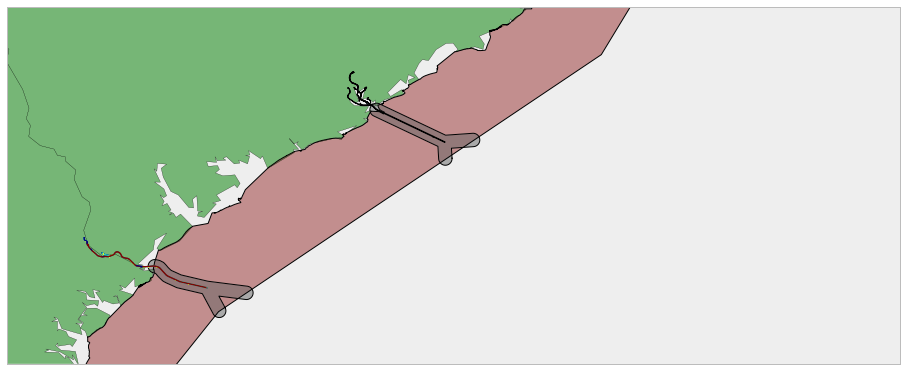

In [16]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
sma_ma.plot(axes=ax, alpha=0.4)
charleston_lanes_buffer.plot(axes=ax, colormap='Accent')
savannah_lanes_buffer.plot(axes=ax, colormap='Accent')
reachesWGS84.plot(axes=ax)
navchannelWGS84.plot(column='Color', axes=ax)

Import survey data and reproject to WGS84, then clip to area of interest.

In [17]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

## Merge and summarize datasets

Perform a merge of survey and habitat data

In [18]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [19]:
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
# HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [82]:
HabModel_merged = HabModelSurveySC.rename(columns=replace_dict).join(HabModelEnviro_points, rsuffix='_env')

Buffer distance to shore

In [85]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

In [21]:
#HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>1000]

Buffer to SMA

In [86]:
intersects_sma = lambda x: bool(np.sum(sma_ma.intersects(x)))
HabModelSMA = gpd.GeoDataFrame(HabModel_merged[HabModel_merged.geometry.apply(intersects_sma).values])

Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [88]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [89]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [93]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Create columns for 2-week period, year and time.

In [96]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor', 'MEAN_depth']
    n_fixed = len(cols)
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[n_fixed:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    if not month:
        year +=1
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [97]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [98]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Add centroid coordinates to DataFrame

In [99]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [100]:
working_data_long = working_data_long.join(centroids)

Extract shipping exposure data, primarily by filtering out ineligible transits (Dec-Mar only).

In [32]:
transits['start_time'] = pd.to_datetime(transits.TR_START, 'D')
transits = transits[transits.start_time.apply(lambda x: (x.month in (12, 1, 2, 3)) and (x.date()<date(2013, 4, 1)))]

In [33]:
transit_times = transits.start_time.astype(object)

In [34]:
month_lookup = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

In [35]:
transits['time'] = transit_times.apply(lambda t: month_lookup[t.month] + str(t.year)[-2:] + ['a','b'][t.day>14])

Drop 2003, given the above, and recode year.

In [102]:
working_data_long['year'] = working_data_long.year - 1
working_data_long = working_data_long[working_data_long.year > 0]

In [103]:
working_data_long.head()

,quad_id,geometry,DistToShor,MEAN_depth,Eff,Grps,Whls,iso,sst,period,year,time,lat,lon
1242,2691,"POLYGON ((-81.0638121503616 31.66385317360051,...",3863.834,-3.8095,15.846747,0,0,96621.078356,15.474,0,1,Dec04a,-81.093142,31.688897
1243,2692,POLYGON ((-81.00520442711309 31.66387073674769...,9203.932,-5.6428,9.329810,1,2,92330.602241,15.940,0,1,Dec04a,-81.034518,31.688928
1244,2693,POLYGON ((-80.94659696259843 31.66386003275813...,12499.129,-10.5952,11.931681,0,0,87950.966394,15.999,0,1,Dec04a,-80.975895,31.688932
1245,2694,"POLYGON ((-80.8879895953431 31.66382227576766,...",16670.382,-12.4523,23.011338,0,0,83711.069405,16.519,0,1,Dec04a,-80.917272,31.688908
1246,2695,POLYGON ((-80.82938237672916 31.66375760271118...,21411.103,-13.3809,23.367187,0,0,79633.234672,16.930,0,1,Dec04a,-80.858649,31.688856


Truncate working data to SMA

In [109]:
working_data_sma = gpd.GeoDataFrame(working_data_long[working_data_long.geometry.apply(intersects_sma).values])

Vessel traffic maps for an arbitrary period

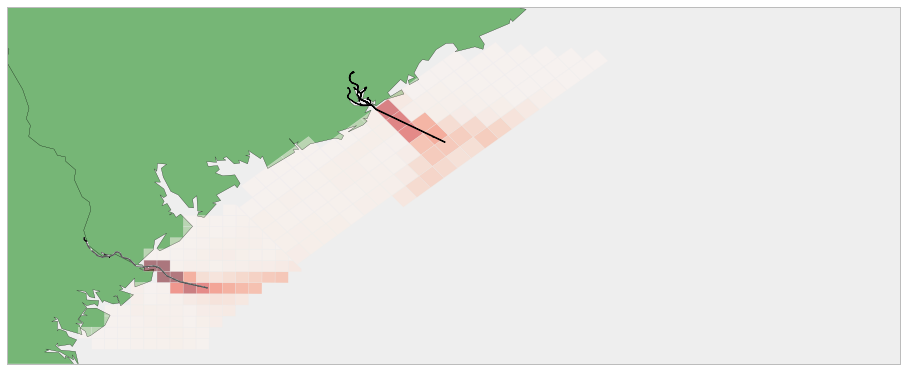

In [110]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(working_data_sma[working_data_sma.time=='Jan13a']).plot(column='traffic', 
                                                                           colormap='Reds', linewidth=0, axes=ax)
reachesWGS84.plot(axes=ax, colormap='Greys')
navchannelWGS84.plot(axes=ax, colormap='Greys')
# sma.plot(axes=ax)

Depth covariate

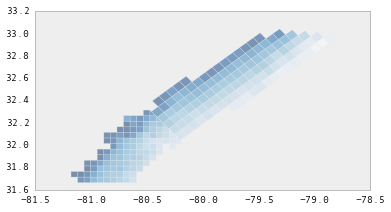

In [362]:
working_data_sma[working_data_sma.time=='Jan12a'].plot(column='MEAN_depth', colormap='Blues', linewidth=0)

ISO

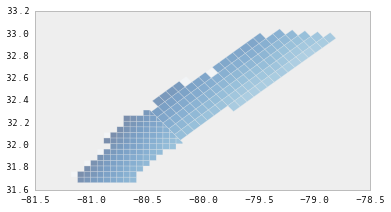

In [363]:
working_data_sma[working_data_sma.time=='Jan12a'].plot(column='iso', colormap='Blues', linewidth=0)

In [111]:
# Missing data
working_data_sma.isnull().sum()

quad_id         0
geometry        0
DistToShor      0
MEAN_depth      0
Eff             0
Grps            0
Whls            0
iso             0
sst           329
period          0
year            0
time            0
lat             0
lon             0
traffic         0
dtype: int64

In [112]:
# Zero-effort cells
(working_data_sma.Eff==0).sum()

3890

In [113]:
dataset = working_data_sma[~((working_data_sma.Eff==0) & (working_data_sma.Grps>0)) 
                            & working_data_sma.sst.notnull()]

# Include rows with positive effort
not_missing = dataset.Eff>0
dataset_surveyed = dataset[not_missing]
# Rows with zero effort is treated as missing data, to be predicted
missing_data = dataset[~not_missing]
centroids = dataset[['lat', 'lon']].values

Generate indicator of whether path starts north of where it ends. This will determine which branch of the lane the ship would likely have used, if it had used the lanes.

In [152]:
transits.ix[1420].geometry.geoms[0].xy

(array('d', [-80.84366499999993, -80.84399799999994]),
 array('d', [32.03833300000008, 32.038500000000056]))

This function creates an indicator variable that identifies transits that would have used the north branch of its respective lane, if it were in place, versus those that would have used the south branch. This is based on the locations where the transits started/ended.

In [153]:
def use_north_lane(x):
    
    first_point = x.geoms[0].xy
    last_point = x.geoms[-1].xy
    
    # Identify inbound our outbound traffic
    inbound = first_point[0][0] > last_point[0][0]
    
    # identify which point is farther north than the other
    if first_point[1][0] > last_point[1][0]:
        
        if inbound:
            return True
        else:
            return False
    
    else:
        if inbound:
            return False
        else:
            return True

In [154]:
# transits['starts_north'] = transits.geometry.apply(lambda x: x.geoms[0].xy[1][0] > x.geoms[-1].xy[1][0])
transits['north_lane'] = transits.geometry.apply(use_north_lane)

Extract transits to each port by intersecting transits with reaches. Create a buffer around each reach, and identify traffic that enter the buffer.

In [155]:
# Buffer Charleston lane
charleston_buffered = reachesWGS84.geometry.buffer(.05).unary_union

# Extract traffic to Charleston
charleston_traffic = transits[transits.geometry.intersects(charleston_buffered)]

In [156]:
charleston_traffic.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry,start_time,time,starts_north,north_lane
1419,3EQL7,Panama (Republic of),Foreign,9181675,294,354618000,Msc Sarah,N,2011-12-01 03:20:18+00,3.18,42.6,2011-2012,107,2011-12-01 00:09:29+00,Cargo,(LINESTRING (-79.85369199999991 32.74656000000...,2011-12-01 00:09:29,Dec11a,True,False
1426,3EMV4,Panama (Republic of),Foreign,9333852,294,371836000,Mol Endowment,N,2011-12-01 07:55:39+00,3.57,39.0,2011-2012,126,2011-12-01 04:21:29+00,Cargo,(LINESTRING (-79.85871299999991 32.75153000000...,2011-12-01 04:21:29,Dec11a,True,False
1427,WDE8264,United States of America,Domestic,9139737,275,367403450,Apl Pearl,N,2011-12-01 08:29:30+00,3.85,38.6,2011-2012,140,2011-12-01 04:38:18+00,Cargo,(LINESTRING (-79.16389499999991 32.66656800000...,2011-12-01 04:38:18,Dec11a,False,False
1428,SXEL,Greece,Foreign,8300121,256,239540000,Msc Austria,N,2011-12-01 16:16:26+00,11.02,105.8,2011-2012,293,2011-12-01 05:15:14+00,Cargo,(LINESTRING (-79.8544169999999 32.747367000000...,2011-12-01 05:15:14,Dec11a,True,True
1433,WKPN,United States of America,Domestic,9193252,292,368348000,Maersk Wisconsin,N,2011-12-01 14:17:33+00,3.49,42.2,2011-2012,122,2011-12-01 10:48:09+00,Cargo,(LINESTRING (-79.08679499999994 32.74795500000...,2011-12-01 10:48:09,Dec11a,True,True


Repeat for Savannah

In [157]:
savannah_buffered = navchannelWGS84.geometry.buffer(.05).unary_union

savannah_traffic = transits[transits.geometry.intersects(savannah_buffered)]

In [158]:
savannah_traffic.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry,start_time,time,starts_north,north_lane
1420,LAOW5,Norway,Foreign,9191319,240,257613000,Talisman,N,2011-12-01 05:11:43+00,2.95,35.5,2011-2012,103,2011-12-01 02:14:33+00,Cargo,(LINESTRING (-80.84366499999993 32.03833300000...,2011-12-01 02:14:33,Dec11a,True,False
1421,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-12-01 03:47:57+00,1.52,25.4,2011-2012,55,2011-12-01 02:16:49+00,Pilot,(LINESTRING (-80.8343549999999 32.035468000000...,2011-12-01 02:16:49,Dec11a,True,False
1422,V7LY9,Marshall Islands (Republic of the),Foreign,9218337,186,538002825,Chios Legacy,N,2011-12-01 05:21:29+00,2.37,28.8,2011-2012,90,2011-12-01 02:59:01+00,Cargo,(LINESTRING (-80.83619999999991 32.03776700000...,2011-12-01 02:59:01,Dec11a,True,False
1423,WDF2357,United States of America,Domestic,0,17,367427760,Carolina,N,2011-12-01 08:44:53+00,5.70,41.7,2011-2012,78,2011-12-01 03:03:05+00,Pilot,(LINESTRING (-80.71335499999992 31.97947500000...,2011-12-01 03:03:05,Dec11a,False,False
1424,KABL,United States of America,Domestic,929868600,292,367606000,Maersk Iowa,N,2011-12-01 09:26:16+00,6.32,88.6,2011-2012,190,2011-12-01 03:06:47+00,Cargo,(LINESTRING (-79.25483299999991 32.35883300000...,2011-12-01 03:06:47,Dec11a,True,True


Remove traffic that crosses both nav channels

In [159]:
crosses_savannah = charleston_traffic.index.isin(savannah_traffic.index)
crosses_charleston = savannah_traffic.index.isin(charleston_traffic.index)

In [160]:
charleston_traffic = charleston_traffic[~crosses_savannah]
savannah_traffic = savannah_traffic[~crosses_charleston]

Sample 2-week period of traffic into Charleston.

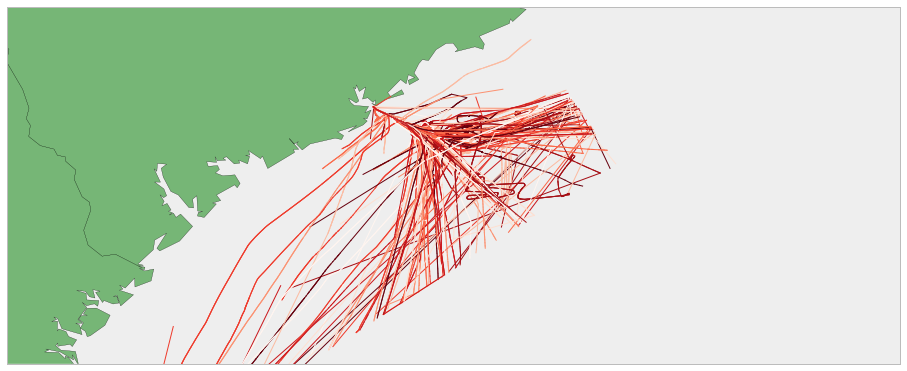

In [652]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

charleston_traffic[charleston_traffic.time=='Jan13a'].plot(colormap='Reds', axes=ax)

Identify the likely lane (within each port) that would correspond to each transit 

In [165]:
transits['charleston_n'] = transits.index.isin(charleston_traffic.index) & transits.north_lane
transits['charleston_s'] = transits.index.isin(charleston_traffic.index) & ~transits.north_lane

transits['savannah_n'] = transits.index.isin(savannah_traffic.index) & transits.north_lane
transits['savannah_s'] = transits.index.isin(savannah_traffic.index) & ~transits.north_lane

Count intersections of hypothetical lane traffic with SMA cells

In [169]:
lane_counts = transits[['charleston_n', 'charleston_s', 'savannah_n', 'savannah_s']].sum()
lane_counts

charleston_n     904
charleston_s    2015
savannah_n      1135
savannah_s      3091
dtype: int64

Identify pathways for northern and southern approaches of each lane

In [161]:
charleston_north = charleston_lanes.drop(1)
charleston_south = charleston_lanes.drop(2)

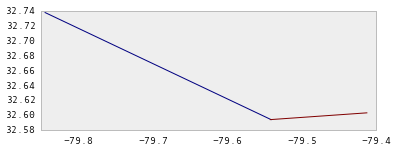

In [123]:
charleston_north.plot()

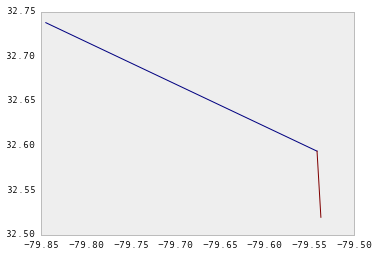

In [124]:
charleston_south.plot()

In [125]:
savannah_north = savannah_lanes.drop(1)
savannah_south = savannah_lanes.copy()
savannah_south.geometry[0] = LineString(savannah_south.geometry[0].coords[:-2])

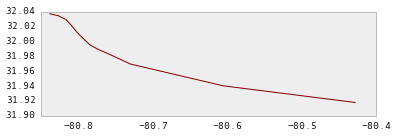

In [126]:
savannah_north.plot()

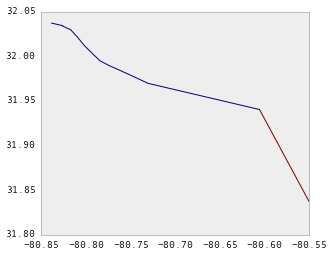

In [127]:
savannah_south.plot()

Count intersections of traffic to each port with SMA cells

In [242]:
# Time intervals for which ship data exist
transit_time_intervals = transits.time.unique()
transit_time_intervals

array(['Dec11a', 'Dec11b', 'Jan12a', 'Jan12b', 'Feb12a', 'Feb12b',
       'Mar12a', 'Mar12b', 'Dec12a', 'Dec12b', 'Jan13a', 'Jan13b',
       'Feb13a', 'Feb13b', 'Mar13a', 'Mar13b'], dtype=object)

In [365]:
import_data = True

traffic_data = {'charleston':charleston_traffic, 'savannah':savannah_traffic}

if not import_data:

    dataset['charleston_obs_traffic'] = 0
    dataset['savannah_obs_traffic'] = 0
    for t in transit_time_intervals:

        for port in traffic_data:
            traffic_dataset = traffic_data[port]
            lines = [shape(g) for g in traffic_dataset[traffic_dataset.time==t].geometry]
            dataset.loc[dataset.time==t, port+'_obs_traffic'] = dataset[
                dataset.time==t].geometry.apply(lambda x: sum([shape(x).intersects(g) for g in lines]))
            
    gpd.GeoDataFrame(dataset).to_file('data/dataset_with_traffic.shp')

In [304]:
if import_data:
    dataset = gpd.GeoDataFrame.from_file('data/dataset_with_traffic.shp').rename({'lane_traff':'lane_traffic',
                                                                             'obs_traffi':'obs_traffic',
                                                                             'charleston':'charleston_obs_traffic',
                                                                             'savannah_o':'savannah_obs_traffic'})

Count intersections of hypothetical lane traffic with SMA cells

In [257]:
assert all(transits[transits[['charleston_n', 'charleston_s', 
                              'savannah_n', 'savannah_s']].sum(1) > 0].time.value_counts())

In [366]:
lanes = {'charleston_n':charleston_north, 'charleston_s':charleston_south, 
         'savannah_n':savannah_north, 'savannah_s':savannah_south}

dataset['charleston_lane_traffic'] = 0
dataset['savannah_lane_traffic'] = 0
for t in transit_time_intervals:
    
    for lane in lanes:
        lane_geom = lanes[lane].geometry
        
        # Function four counting intersections with lane
        f = lambda g: int(any([g.intersects(x) for x in lane_geom.geometry]))
        
        # Number of transits assigned to this lane at this time
        lane_transits = transits.loc[transits.time==t, lane].sum()
        
        dataset.loc[dataset.time==t, lane[:-1]+'lane_traffic'] += dataset[dataset.time==t].geometry.apply(f) * lane_transits

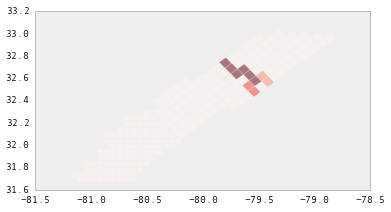

In [367]:
dataset[dataset.time=='Dec12a'].plot(column='charleston_lane_traffic', colormap='Reds', linewidth=0)

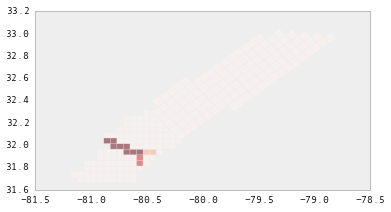

In [368]:
dataset[dataset.time=='Dec12a'].plot(column='savannah_lane_traffic', colormap='Reds', linewidth=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x29d6fc9e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x29f181898>]], dtype=object)

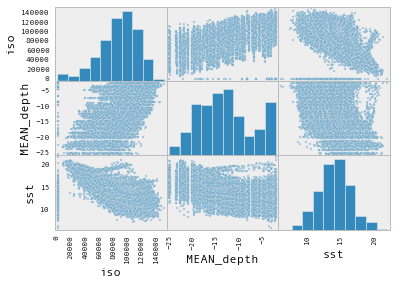

In [659]:
pd.scatter_matrix(dataset[['iso', 'MEAN_depth', 'sst']])

## Conditional autoregressive model of whale occurrence

One of the key features of this analysis is the modeling of spatial autocorrelation via conditional autoregression methods. Since the number of surveys and sightings are limited, we need to borrow strength among the grid cells of the region, recognizing that an animal observed in one cell is likely to also be in neighboring cells within the same period. The CAR model accounts for the spatial covariance directly, here estimating a risk surface of whale occurrence.

In [369]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli, Poisson, Gamma
from pymc import Lambda, MCMC, invlogit, AdaptiveMetropolis, MCMC, normal_like
from pymc import potential, deterministic, stochastic, rnormal

Create mesh of area from grid centroids.

In [370]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T*np.pi/180.

Extract columns of interest from dataset.

In [380]:
(lat, lon, period, year, sst, iso, charleston_obs_traffic, 
                                   charleston_lane_traffic, 
                                   savannah_obs_traffic, 
                                   savannah_lane_traffic, depth) = dataset[['lat', 
                                                                            'lon', 
                                                                            'period', 
                                                                            'year', 
                                                                            'sst', 
                                                                            'iso', 
                                                                            'charleston_obs_traffic', 
                                                                            'charleston_lane_traffic', 
                                                                            'savannah_obs_traffic', 
                                                                            'savannah_lane_traffic', 
                                                                            'MEAN_depth']].values.T
period = period.astype(int)

Use grouped dataset to extract summary values for each polygon

In [372]:
df_geo = dataset.fillna({'obs_traffic':0}).groupby('quad_id')

In [381]:
# Columns that need to be averaged
data_summarized = df_geo[['lat', 'lon', 'sst', 'iso', 'MEAN_depth']].mean()
# Columns that need to be summed
data_summarized[['charleston_obs_traffic', 
                 'charleston_lane_traffic', 
                 'savannah_obs_traffic', 
                 'savannah_lane_traffic', 
                 'Grps', 
                 'Whls', 
                 'Eff']] = df_geo[['charleston_obs_traffic', 
                                   'charleston_lane_traffic', 
                                   'savannah_obs_traffic', 
                                   'savannah_lane_traffic', 'Grps', 'Whls', 'Eff']].sum()
data_summarized['geometry'] = df_geo['geometry'].first()
data_summarized.head()

,lat,lon,sst,iso,MEAN_depth,charleston_obs_traffic,charleston_lane_traffic,savannah_obs_traffic,savannah_lane_traffic,Grps,Whls,Eff,geometry
quad_id,,,,,,,,,,,,,
2691,-81.093142,31.688897,13.256247,119200.031023,-3.8095,0,0,3,0,0,0,1870.059657,"POLYGON ((-81.0638121503616 31.66385317360051,..."
2692,-81.034518,31.688928,13.469918,114477.800710,-5.6428,0,0,7,0,1,2,2388.797729,POLYGON ((-81.00520442711309 31.66387073674769...
2693,-80.975895,31.688932,13.618718,109732.472247,-10.5952,0,0,16,0,0,0,2389.803678,POLYGON ((-80.94659696259843 31.66386003275813...
2694,-80.917272,31.688908,13.738225,104984.253630,-12.4523,0,0,21,0,2,3,2350.584436,"POLYGON ((-80.8879895953431 31.66382227576766,..."
2695,-80.858649,31.688856,13.886081,100228.491291,-13.3809,1,0,19,0,1,1,2304.253170,POLYGON ((-80.82938237672916 31.66375760271118...


Confirm no missing values

In [382]:
assert not data_summarized.isnull().sum().any()

Distribution of effort across cells

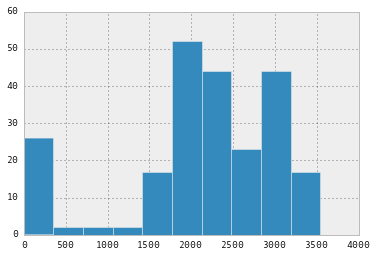

In [383]:
data_summarized.Eff.hist()

Remove unsurveyed polygons

In [384]:
data_surveyed = data_summarized[data_summarized.Eff>0]

Normalize SST, ISO and depth

In [385]:
normalize = lambda x: np.array((x - x.mean()) / x.std())

In [386]:
sst_norm = normalize(data_surveyed.sst)
iso_norm = normalize(data_surveyed.iso)
depth_norm = normalize(data_surveyed.MEAN_depth)

In [387]:
charleston_lane_traffic = data_surveyed.charleston_lane_traffic.values
charleston_obs_traffic = data_surveyed.charleston_obs_traffic.values
savannah_lane_traffic = data_surveyed.savannah_lane_traffic.values
savannah_obs_traffic = data_surveyed.savannah_obs_traffic.values

In [388]:
groups, whales, effort = data_surveyed[['Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)

Scale effort by a factor of 100 to avoid numerical issues

In [389]:
effort = effort/100.

Generate neighborhood matrix for all polygons, to be used in the first-order conditional autoregressive model.

In [390]:
data_gdf = gpd.GeoDataFrame(data_surveyed)

In [391]:
neighbors = np.array([data_gdf.geometry.touches(v).values for i, v in data_gdf.geometry.iteritems()])

### Non-parametric regression sub-model

In order to avoid making assumptions about the functional form of the relationship between spatial covariates (water depth and sea surface temperature) and the encounter rate with whale groups. For each variable, we specify a 5-knot spline function over range of the variables. The result is a flexible, non-parametric function that is not constrained by assumptions of form.

In [533]:
def spline(name, x, knots, interpolation_method='linear'):
    """ Generate PyMC objects for a spline model

    Parameters
    ----------
    name : str
    knots : array
    x : array, points to interpolate to
    interpolation_method : str, optional, one of 'linear', 'nearest', 'zero', 'slinear', 'quadratic, 'cubic'

    Results
    -------
    Returns dict of PyMC objects, including 'gamma' (log of rate at
    knots) and 'mu' (rate interpolated at all points)
    """
    
    if np.isscalar(knots):
        knots = np.linspace(x.min(), x.max(), knots)
    
    assert np.all(np.diff(knots) > 0), 'Spline knots must be strictly increasing'

    gamma = [Normal('gamma_%s_%d' % (name,i), 0., 10.**-2, value=-10.) for i,k in enumerate(knots)]

    import scipy.interpolate
    @deterministic(name='mu_%s'%name)
    def mu(gamma=gamma, knots=knots, x=x):
        mu = scipy.interpolate.interp1d(knots, gamma, kind=interpolation_method, bounds_error=False, 
                                        fill_value=0.)
        return mu(x)

    vars = dict(gamma=gamma, mu=mu, x=x, knots=knots)

    return vars

### Conditional autoregressive (CAR) model

In order to allow for the spatial autocorrelation of whale group observations, we implemented a first-order conditional autoregressive model, which expresses the effect in the current cell $k$ as a Gaussian-distributed random variable, with a mean equal to the weighted average of the direct neighbors (typically 8 cells). 

![CAR](http://d.pr/i/11AkN+)

Here, we equally weight all neighbors, $w_{ki} = 1 \, \forall \, i,k$.

In [663]:
def spline_car_model():
        
    sp_sst = spline('sst', sst_norm, 5)
        
    sp_depth = spline('depth', depth_norm, 5)
    
    # CAR component
    ϕ = Uninformative('ϕ', value=np.zeros(len(groups)))
    τ_car = Exponential('τ_car', 1, value=1)
    
    @potential
    def car(ϕ=ϕ, τ=τ_car):
        
        n = neighbors.sum(0).astype(float)
        
        return normal_like(ϕ, ϕ.dot(neighbors)/n, n*τ)

    # Occurrence rate
    @deterministic
    def θ(β1=sp_sst['mu'], β2=sp_depth['mu'], phi=ϕ):
        return np.exp(β1 + β2 + phi) 

    λ = Lambda('λ', lambda θ=θ: θ * effort)
        
    # Likelihood
    group_obs = Poisson('group_obs', λ, value=groups, observed=True)
    
    # Risk of observed traffic
    charleston_obs_risk = Lambda('charleston_obs_risk', lambda theta=θ: theta*charleston_obs_traffic)
    savannah_obs_risk = Lambda('savannah_obs_risk', lambda theta=θ: theta*savannah_obs_traffic)
    
    cha_sum_obs_risk = Lambda('cha_sum_obs_risk', lambda r=charleston_obs_risk: np.sum(r))
    sav_sum_obs_risk = Lambda('sav_sum_obs_risk', lambda r=savannah_obs_risk: np.sum(r))

    # Risk of lane traffic
    charleston_lane_risk = Lambda('charleston_lane_risk', lambda theta=θ: theta*charleston_lane_traffic)
    savannah_lane_risk = Lambda('savannah_lane_risk', lambda theta=θ: theta*savannah_lane_traffic)
    
    cha_sum_lane_risk = Lambda('cha_sum_lane_risk', lambda r=charleston_lane_risk: np.sum(r))
    sav_sum_lane_risk = Lambda('sav_sum_lane_risk', lambda r=savannah_lane_risk: np.sum(r))
    
    cha_reduction = Lambda('cha_reduction', lambda o=cha_sum_obs_risk, l=cha_sum_lane_risk: (o-l)/o)
    sav_reduction = Lambda('sav_reduction', lambda o=sav_sum_obs_risk, l=sav_sum_lane_risk: (o-l)/o)
               
    return locals()

Instantiate and run MCMC model

In [664]:
M = MCMC(spline_car_model())

In [665]:
M.sample(500000, 400000)

 [-----------------100%-----------------] 500000 of 500000 complete in 1224.1 sec

## Model output

The following graphical summaries show the posterior distribution of key parameters.


Basis function variances for sea surface temperature effect

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


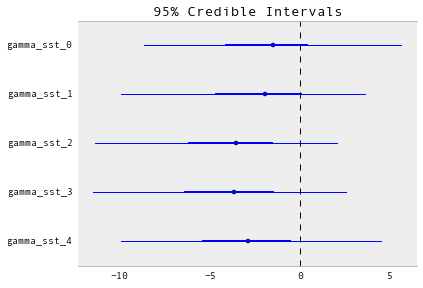

In [666]:
from pymc import Matplot

Matplot.summary_plot(M.__dict__['sp_sst']['gamma'])

Non-parametric depth effect (recall that depth is expressed in negative values in the dataset)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


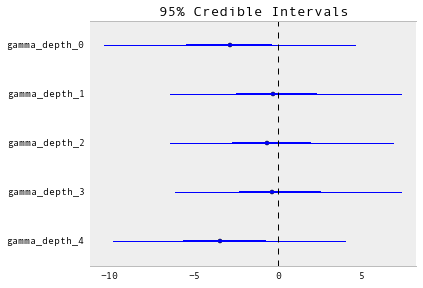

In [667]:
Matplot.summary_plot(M.__dict__['sp_depth']['gamma'])

Plot of the mean depth effect

In [670]:
def plot_series(series, data=data_surveyed, cmap='Reds'):
    
    gdf = gpd.GeoDataFrame(data)
    
    fig = plt.figure(figsize=(16,12))
    ax = plt.gca()
    basemap_sc.drawstates(linewidth=0.15)
    basemap_sc.drawcoastlines(linewidth=0.25)
    basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
    gdf.plot(column=series, colormap=cmap, linewidth=0, axes=ax)
    navchannelWGS84.plot(column='Color', axes=ax)
    reachesWGS84.plot(column='reachCode', axes=ax)

In [671]:
data_surveyed['depth_effects'] = M.__dict__['sp_depth']['mu'].stats()['mean']

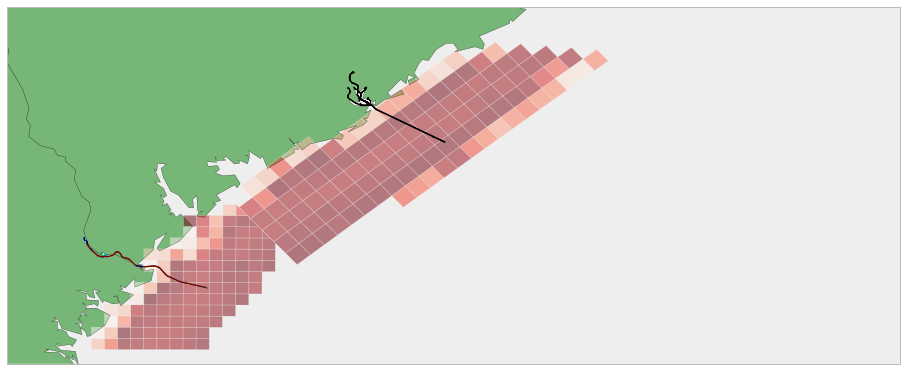

In [672]:
plot_series('depth_effects')

Spatial autocorrelation effect

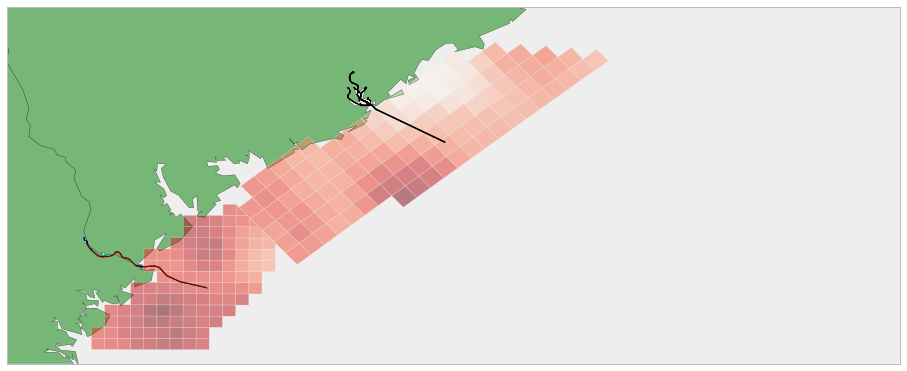

In [686]:
plot_series('phi')

Expected encounter rate

In [673]:
data_surveyed['p_pred'] = M.θ.stats()['mean']

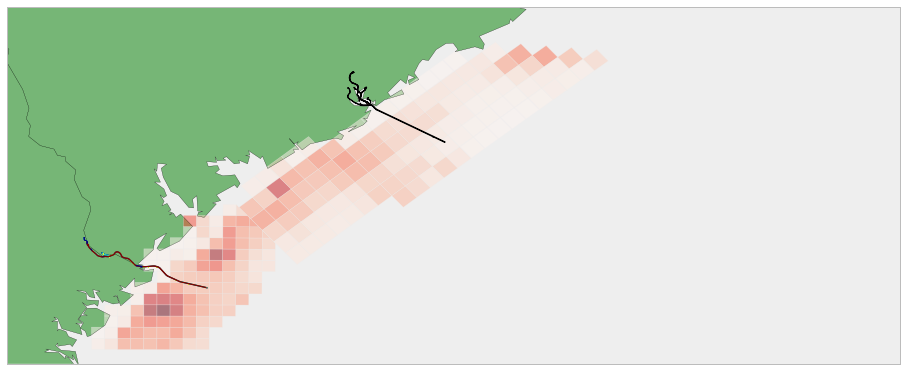

In [674]:
plot_series('p_pred')

### Estimate of risk based on past traffic in Charleston

*i.e.* no lanes

In [675]:
data_surveyed['charleston_obs_risk'] = M.charleston_obs_risk.stats()['mean']

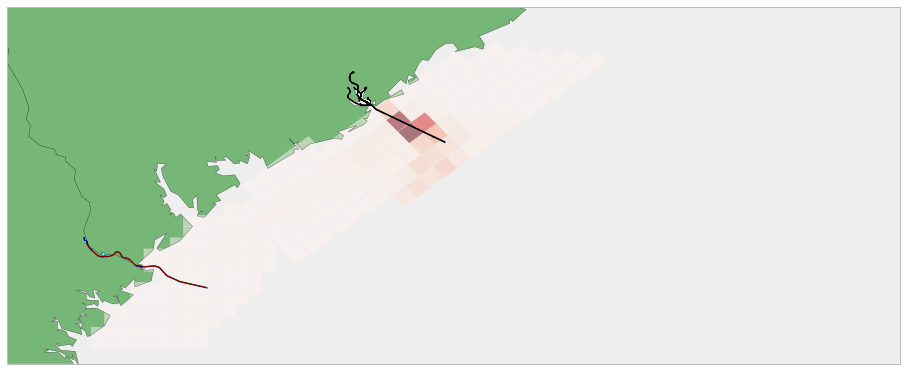

In [676]:
plot_series('charleston_obs_risk')

### Estimate of risk based on proposed lanes in Charleston

In [677]:
data_surveyed['charleston_lane_risk'] = M.charleston_lane_risk.stats()['mean']

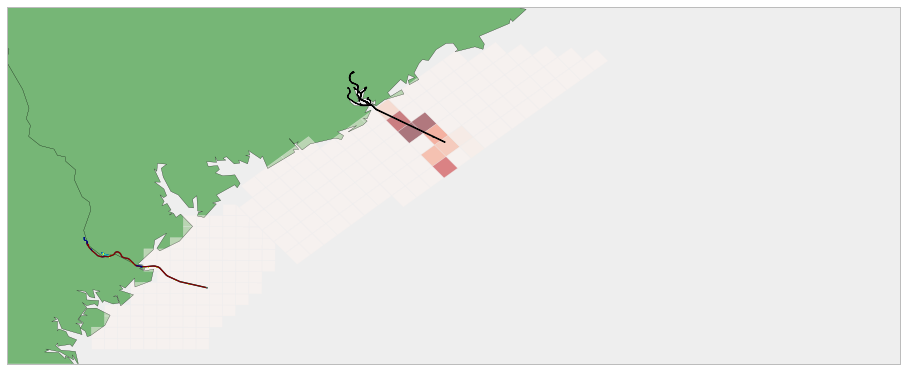

In [678]:
plot_series('charleston_lane_risk')

### Estimate of risk based on past traffic in Savannah

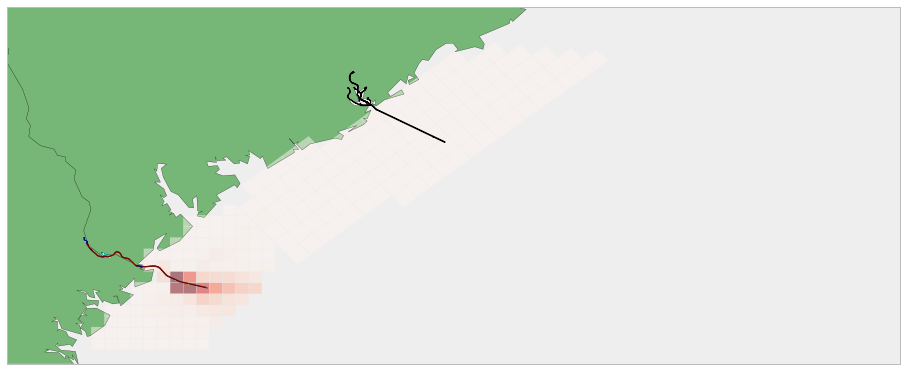

In [679]:
data_surveyed['savannah_obs_risk'] = M.savannah_obs_risk.stats()['mean']
plot_series('savannah_obs_risk')

### Estimate of risk based on proposed lanes in Savannah

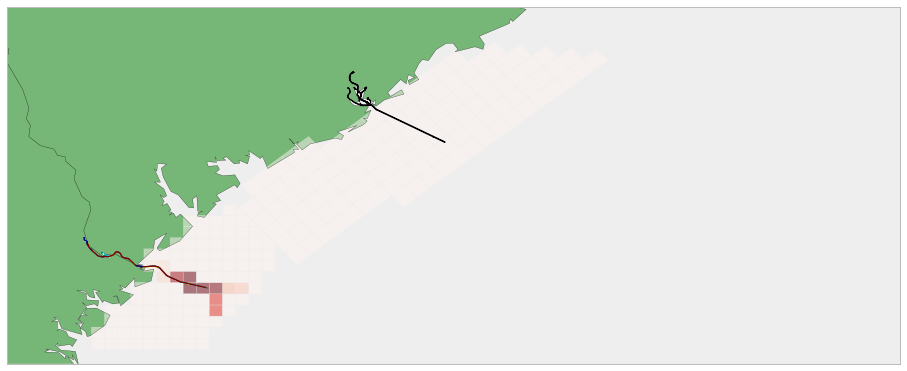

In [680]:
data_surveyed['savannah_lane_risk'] = M.savannah_lane_risk.stats()['mean']
plot_series('savannah_lane_risk')

## Plots of total expected risk for Charleston

This is a plot of the expected risk, under both scenarios, summed over all cells. The Plot includes 95% posterior credible intervals.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


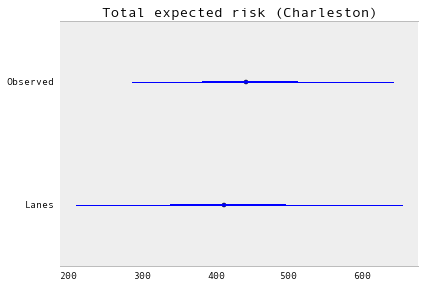

In [681]:
Matplot.summary_plot([M.cha_sum_obs_risk, M.cha_sum_lane_risk], custom_labels=['Observed', 'Lanes'],
                    main='Total expected risk (Charleston)')

This calculates the estimated mean percent reduction in total risk.

In [682]:
(M.cha_sum_obs_risk.stats()['mean'] - M.cha_sum_lane_risk.stats()['mean']) / M.cha_sum_obs_risk.stats()['mean']

0.061238479275200014

## Plot of total expected risk for Savannah

This is a plot of the expected risk, under both scenarios, summed over all cells. The Plot includes 95% posterior credible intervals.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


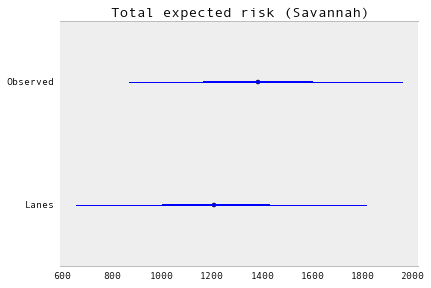

In [683]:
Matplot.summary_plot([M.sav_sum_obs_risk, M.sav_sum_lane_risk], custom_labels=['Observed', 'Lanes'],
                    main='Total expected risk (Savannah)')

This calculates the estimated mean percent reduction in total risk.

In [684]:
(M.sav_sum_obs_risk.stats()['mean'] - M.sav_sum_lane_risk.stats()['mean']) / M.sav_sum_obs_risk.stats()['mean']

0.12271574596419794

### Distribution of percent reduction in risk with lanes versus without

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


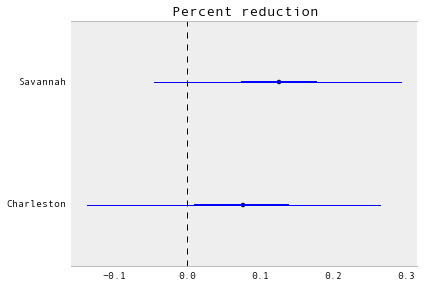

In [685]:
Matplot.summary_plot([M.sav_reduction, M.cha_reduction], custom_labels=['Savannah', 'Charleston'],
                    main='Percent reduction')